## Installing `giskard`

In [2]:
#!pip install giskard

## Connect the external worker in daemon mode

In [3]:
#!giskard worker start -d

# Start by creating an ML model 🚀🚀🚀

Let's create a credit scoring Model using the German Credit scoring dataset [(Link](https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification) to download the dataset)

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import model_selection
from sklearn import preprocessing
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import nn, optim
from torch.autograd import Variable
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, \
    RocCurveDisplay, accuracy_score
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE, SMOTENC


In [45]:
# To download and read the credit scoring dataset
url = 'https://raw.githubusercontent.com/Giskard-AI/examples/main/datasets/credit_scoring_classification_model_dataset/german_credit_prepared.csv'
credit = pd.read_csv(url, sep=',',engine="python") #To download go to https://github.com/Giskard-AI/giskard-client/tree/main/sample_data/classification

In [46]:
# Declare the type of each column in the dataset(example: category, numeric, text)
column_types = {'default':"category",
               'account_check_status':"category", 
               'duration_in_month':"numeric",
               'credit_history':"category",
               'purpose':"category",
               'credit_amount':"numeric",
               'savings':"category",
               'present_employment_since':"category",
               'installment_as_income_perc':"numeric",
               'sex':"category",
               'personal_status':"category",
               'other_debtors':"category",
               'present_residence_since':"numeric",
               'property':"category",
               'age':"numeric",
               'other_installment_plans':"category",
               'housing':"category",
               'credits_this_bank':"numeric",
               'job':"category",
               'people_under_maintenance':"numeric",
               'telephone':"category",
               'foreign_worker':"category"}

In [47]:
# feature_types is used to declare the features the model is trained on
feature_types = {i: column_types[i] for i in column_types if i != 'default'}

# Pipeline to fill missing values, transform and scale the numeric columns
columns_to_scale = [key for key in feature_types.keys()
                    if feature_types[key] == "numeric"]
numeric_transformer = Pipeline([('imputer', SimpleImputer(strategy='median')),
                                ('scaler', StandardScaler())])

# Pipeline to fill missing values and one hot encode the categorical values
columns_to_encode = [
    key for key in feature_types.keys() if feature_types[key] == "category"]
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))])

# Perform preprocessing of the columns with the above pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_to_scale),
        ('cat', categorical_transformer, columns_to_encode)
    ]
)

# Pipeline for the model Logistic Regression
clf_logistic_regression = Pipeline(
    steps=[('preprocessor', preprocessor),
           ('classifier', LogisticRegression(max_iter=1000))])

dummy_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', DummyClassifier())])

# Split the data into train and test
y = credit['default']
X = credit.drop(columns='default')
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, test_size=0.20, random_state=30, stratify=y)

In [9]:
clf_logistic_regression.fit(X_train, y_train)
dummy_pipeline.fit(X_train, y_train)

y_pred_test_log = clf_logistic_regression.predict(X_test)
y_pred_test_dum = dummy_pipeline.predict(X_test)

print(f"Dummy's classifier accuracy is : \
{format(accuracy_score(y_test, y_pred_test_dum))}\
\nLogisticRegression's accuracy is : \
{format(accuracy_score(y_test, y_pred_test_log))}")

Dummy's classifier accuracy is : 0.7
LogisticRegression's accuracy is : 0.755


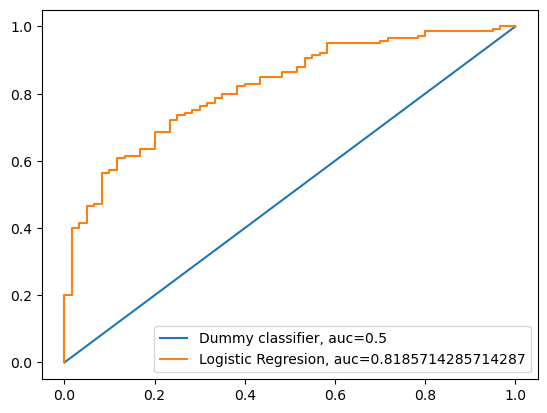

In [10]:
y_proba_log = clf_logistic_regression.predict_proba(X_test)[:, 1]
y_proba_dum = dummy_pipeline.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_proba_dum, pos_label='Not default')
auc = roc_auc_score(y_test, y_proba_dum)
plt.plot(fpr, tpr, label="Dummy classifier, auc="+str(auc, ))

fpr, tpr, _ = roc_curve(y_test, y_proba_log, pos_label='Not default')
auc = roc_auc_score(y_test, y_proba_log)
plt.plot(fpr, tpr, label="Logistic Regresion, auc="+str(auc))

plt.legend()


In [11]:
# Prepare data to upload on Giskard
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test ], axis=1)

# Upload the model in Giskard 🚀🚀🚀

### Initiate a project

In [108]:
# from giskard import GiskardClient

# url = "http://localhost:19000" 
# # if Giskard is installed locally (for installation, see: https://docs.giskard.ai/start/guides/installation)

# # url = "http://app.giskard.ai" #
# # If you want to upload on giskard URL
# token = "YOUR GENERATED TOKEN" # you can generate your API token in the Admin tab of the Giskard application (for installation, see: https://docs.giskard.ai/start/guides/installation)

# client = GiskardClient(url, token)

# # your_project = client.create_project("project_key", "PROJECT_NAME", "DESCRIPTION")
# # Choose the arguments you want. But "project_key" should be unique and in lower case
# credit_scoring = client.create_project("credit_scoring", "German Credit Scoring", "Project to predict if user will default")

# # If you've already created a project with the key "credit-scoring" use
# #credit_scoring = client.get_project("credit_scoring")


### Upload your model and a dataset (see [documentation](https://docs.giskard.ai/start/guides/upload-your-model))

In [ ]:
credit_scoring.upload_model_and_df(
    prediction_function=clf_logistic_regression.predict_proba, # Python function which takes pandas dataframe as input and returns probabilities for classification model OR returns predictions for regression model
    model_type='classification', # "classification" for classification model OR "regression" for regression model
    df=test_data, # the dataset you want to use to inspect your model
    column_types=column_types, # A dictionary with columns names of df as key and types(category, numeric, text) of columns as values
    target='default', # The column name in df corresponding to the actual target variable (ground truth).
    feature_names=list(feature_types.keys()), # List of the feature names of prediction_function
    classification_labels=clf_logistic_regression.classes_ ,  # List of the classification labels of your prediction
    model_name='logistic_regression_v1', # Name of the model
    dataset_name='test_data' # Name of the dataset
)

### 🌟 If you want to upload a dataset without a model






For example, let's upload the train set in Giskard, this is key to create drift tests in Giskard.


In [ ]:
credit_scoring.upload_df(
    df=train_data, # The dataset you want to upload
    column_types=column_types, # All the column types of df
    target="default", # Do not pass this parameter if dataset doesn't contain target column
    name="train_data" # Name of the dataset
)

You can also upload new production data to use it as a validation set for your existing model. In that case, you might not have the ground truth target variable

In [ ]:
production_data = credit.drop(columns="default")

In [ ]:
credit_scoring.upload_df(
    df=production_data, # The dataset you want to upload
    column_types=feature_types, # All the column types without the target
    name="production_data"# Name of the dataset
)

### 🌟 If you just want to upload a model without a dataframe 

This happens for instance when you built a new version of the model and you want to inspect it using a validation dataframe that is already in Giskard

For example, let's create a second version of the model using random forest

In [ ]:
clf_random_forest = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier(max_depth=10,random_state=0))])

clf_random_forest.fit(X_train, y_train)
clf_random_forest.score(X_test, y_test)

In [ ]:
credit_scoring.upload_model(
    prediction_function=clf_random_forest.predict_proba, # Python function which takes pandas dataframe as input and returns probabilities for classification model OR returns predictions for regression model
    model_type='classification', # "classification" for classification model OR "regression" for regression model
    feature_names=list(feature_types.keys()), # List of the feature names of prediction_function
    name='random_forest', # Name of the model
    validate_df=train_data, # Optional. Validation df is not uploaded in the app, it's only used to check whether the model has the good format
    target="default", # Optional. target should be a column of validate_df. Pass this parameter only if validate_df is being passed
    classification_labels=["Default","Not default"] # List of the classification labels of your prediction

)

# Happy Exploration ! 🧑‍🚀

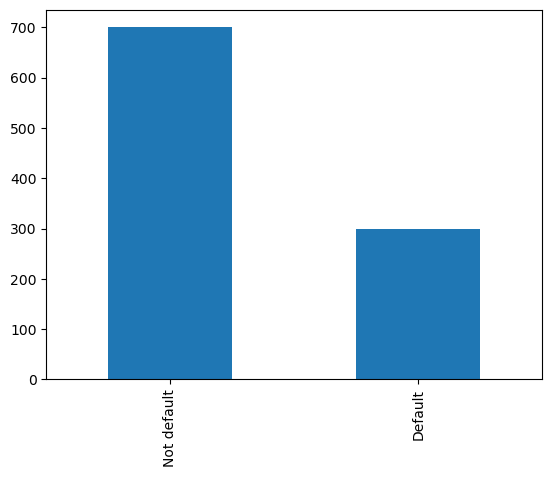

In [24]:
credit.default.value_counts().plot(kind='bar')
plt.show()

The dataset is quite imbalanced. We will try to strengthen it by 2 different methods.  
## Undersampling

<AxesSubplot:>

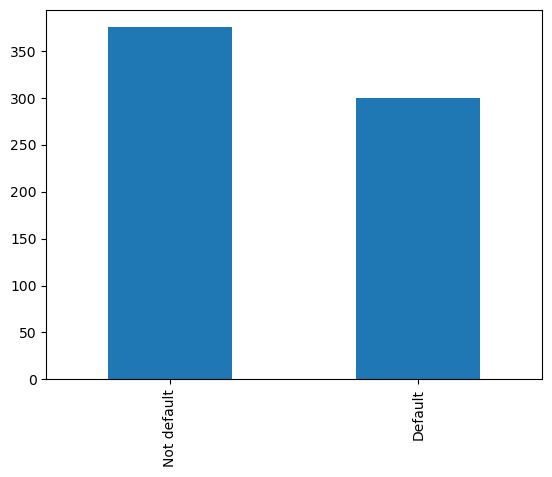

In [20]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.8)
X_under, Y_under = undersample.fit_resample(X, y)
Y_under.value_counts().plot(kind='bar')

## Oversampling

<AxesSubplot:>

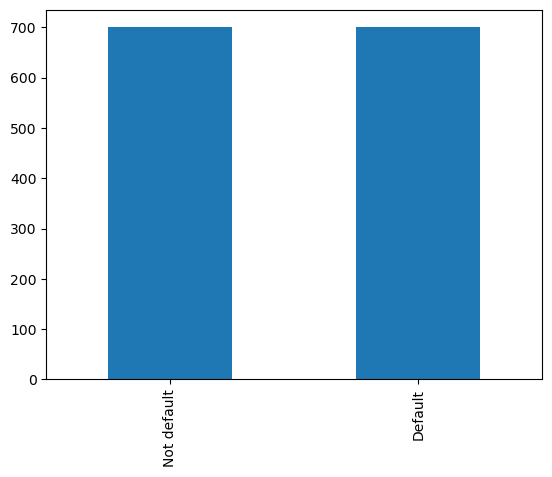

In [26]:
indices = X.columns.get_indexer(columns_to_encode)
oversample = SMOTENC(categorical_features=indices)
X_over, y_over = oversample.fit_resample(X, y)
y_over.value_counts().plot(kind='bar')

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_over, y_over, test_size=0.20, random_state=30, stratify=y_over)

clf_logistic_regression.fit(X_train, y_train)
y_pred_test_over = clf_logistic_regression.predict(X_test)

print(f"Dummy's classifier accuracy is : \
{format(accuracy_score(y_test, y_pred_test_over))}")


Dummy's classifier accuracy is : 0.7892857142857143


## Variational autoencoder for Tabular Data

In [68]:
DATA_PATH = 'data/wine.csv'

def load_and_standardize_data(path):
    # read in from csv
    df = pd.read_csv(path, sep=',')
    # # replace nan with -99
    df = df.fillna(-99)
    df = df.values.reshape(-1, df.shape[1]).astype('float32')
    # randomly split
    df = credit
    X_train, X_test = train_test_split(df, test_size=0.3, random_state=42)
    # standardize values
    scaler = preprocessing.StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)   
    return X_train, X_test, scaler

from torch.utils.data import Dataset, DataLoader
class DataBuilder(Dataset):
    def __init__(self, path, train=True):
        self.X_train, self.X_test, self.standardizer = load_and_standardize_data(DATA_PATH)
        if train:
            self.x = torch.from_numpy(self.X_train)
            self.len=self.x.shape[0]
        else:
            self.x = torch.from_numpy(self.X_test)
            self.len=self.x.shape[0]
        del self.X_train
        del self.X_test 
    def __getitem__(self,index):      
        return self.x[index]
    def __len__(self):
        return self.len

In [69]:
traindata_set=DataBuilder(DATA_PATH, train=True)
testdata_set=DataBuilder(DATA_PATH, train=False)

trainloader=DataLoader(dataset=traindata_set,batch_size=1024)
testloader=DataLoader(dataset=testdata_set,batch_size=1024)

FileNotFoundError: [Errno 2] No such file or directory: 'data/wine.csv'

In [36]:
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
from keras.losses import binary_crossentropy

def create_vae(categorical_dim, numerical_dim, latent_dim):
    # encoder
    categorical_inputs = Input(shape=(categorical_dim,))
    x = Lambda(lambda x: to_categorical(x))(categorical_inputs)
    numerical_inputs = Input(shape=(numerical_dim,))
    inputs = Concatenate()([x, numerical_inputs])
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    encoder = Model(inputs=[categorical_inputs, numerical_inputs], outputs=[z_mean, z_log_var])
    
    # decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(latent_inputs)
    x = Dense(64, activation='relu')(x)
    categorical_outputs = Dense(categorical_dim, activation='softmax')(x)
    numerical_outputs = Dense(numerical_dim)(x)
    decoder = Model(inputs=latent_inputs, outputs=[categorical_outputs, numerical_outputs])
    
    # VAE
    outputs = decoder(encoder([categorical_inputs, numerical_inputs])[0])
    vae = Model(inputs=[categorical_inputs, numerical_inputs], outputs=outputs)
    
    # loss
    def vae_loss(y_true, y_pred):
        categorical_true, numerical_true = y_true
        categorical_pred, numerical_pred = y_pred
        categorical_loss = K.categorical_crossentropy(categorical_true, categorical_pred)
        numerical_loss = K.mean(K.square(numerical_true - numerical_pred), axis=-1)
        return categorical_loss + numerical_loss
    
    vae.compile(optimizer='adam', loss=vae_loss)
    return vae

In [97]:
import tensorflow as tf
from keras.layers import Input, Dense, Lambda, Concatenate
from keras.models import Model
from keras.utils import to_categorical
from keras import backend as K
from keras.losses import binary_crossentropy

from sklearn.preprocessing import LabelEncoder
import numpy as np


def create_vae(categorical_dim, numerical_dim, latent_dim):
    # encoder
    categorical_inputs = Input(shape=(categorical_dim,))
    #x = Lambda(lambda x: tf.argmax(x, axis=1))(categorical_inputs)
    x = Lambda(lambda x: tf.keras.utils.to_categorical(x, num_classes=categorical_dim))(categorical_inputs)
    #categorical_inputs = to_categorical(categorical_inputs.values)
    numerical_inputs = Input(shape=(numerical_dim,))
    inputs = Concatenate()([x, numerical_inputs])
    x = Dense(64, activation='relu')(inputs)
    x = Dense(64, activation='relu')(x)
    z_mean = Dense(latent_dim)(x)
    z_log_var = Dense(latent_dim)(x)
    encoder = Model(inputs=[categorical_inputs, numerical_inputs], outputs=[z_mean, z_log_var])
    
    # decoder
    latent_inputs = Input(shape=(latent_dim,))
    x = Dense(64, activation='relu')(latent_inputs)
    x = Dense(64, activation='relu')(x)
    categorical_outputs = Dense(categorical_dim, activation='softmax')(x)
    numerical_outputs = Dense(numerical_dim)(x)
    binary_output = Dense(1, activation='sigmoid')(x)
    decoder = Model(inputs=latent_inputs, outputs=[categorical_outputs, numerical_outputs,binary_output])
    
    # VAE
    outputs = decoder(encoder([categorical_inputs, numerical_inputs])[0])
    vae = Model(inputs=[categorical_inputs, numerical_inputs], outputs=outputs[2])
    
    # loss
    def vae_loss(y_true, y_pred):
        binary_loss = binary_crossentropy(y_true, y_pred)
        return binary_loss
    
    vae.compile(optimizer='adam', loss=vae_loss)
    return vae

In [98]:
credit[columns_to_encode] = credit[columns_to_encode].astype('string')
X_categorical_np = pd.get_dummies(credit[columns_to_encode])
X_numerical_np = credit.drop(columns_to_encode+['default'], axis=1).values
X = np.concatenate((X_categorical_np, X_numerical_np), axis=1)
y = credit['default'].values

scaler=StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

encoder = LabelEncoder()
y = encoder.fit_transform(y)

categorical_dim = len(columns_to_encode)
numerical_dim = len(columns_to_scale)

#X_categorical_np = credit[columns_to_encode].values
X_categorical_np = to_categorical(credit[columns_to_encode].values)
X_numerical_np = credit[columns_to_scale].values

credit.default = credit.default.replace({"Default": 1, "Not default": 0})
y_binary_np = credit.default.values

latent_dim = 3

vae = create_vae(categorical_dim, numerical_dim, latent_dim)
vae.fit([X_categorical_np, X_numerical_np], y_binary_np, epochs=100, batch_size=32)

ValueError: invalid literal for int() with base 10: '< 0 DM'

In [95]:
columns_to_scale

['duration_in_month',
 'credit_amount',
 'installment_as_income_perc',
 'present_residence_since',
 'age',
 'credits_this_bank',
 'people_under_maintenance']

In [ ]:
latent_values = np.random.normal(size=(1, latent_dim))
new_categorical, new_numerical = vae.decoder.predict(latent_values)

In [96]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

credit[columns_to_encode] = credit[columns_to_encode].astype('string')
X_categorical_np = pd.get_dummies(credit[columns_to_encode])
X_numerical_np = credit.drop(columns_to_encode+['default'], axis=1).values
X = np.concatenate((X_categorical_np, X_numerical_np), axis=1)
y = credit['default'].values

scaler=StandardScaler()
X_train[columns_to_scale] = scaler.fit_transform(X_train[columns_to_scale])

encoder = LabelEncoder()
y = encoder.fit_transform(y)

latent_dim = 2
input_dim = X_train.shape[1]

encoder_inputs = Input(shape=(input_dim, ), name='encoder_input')
x = Dense(32, activation='relu')(encoder_inputs)
x = Dense(16, activation='relu')(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# Reparametrization trick
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(z_log_var / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

encoder = Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')

latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(16, activation='relu')(latent_inputs)
x = Dense(32, activation='relu')(x)
decoder_outputs = Dense(input_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, decoder_outputs, name='decoder')

outputs = decoder(encoder(encoder_inputs)[2])
vae = Model(encoder_inputs, outputs, name='vae')

reconstruction_loss = binary_crossentropy(encoder_inputs, outputs)
reconstruction_loss *= input_dim
kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vae.compile(optimizer='adam', loss=vae_loss)
vae.fit(X_train, X_train, epochs=50, batch_size=32)



TypeError: Keras symbolic inputs/outputs do not implement `__len__`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model. This error will also get raised if you try asserting a symbolic input/output directly.

## GAN

In [68]:
from keras.layers import Input, Dense, LeakyReLU, Dropout, Concatenate
from keras.models import Model, Sequential
import tensorflow as tf
from tensorflow import convert_to_tensor
from sklearn.preprocessing import MinMaxScaler

data = credit
output_dim = data.shape[1]
input_dim = output_dim
data.default = data.default.replace({"Default": 1, "Not default": 0})

epochs = 300
# Preprocessing function
def preprocess_data(data, columns_to_encode, columns_to_scale):
    # One-hot encode categorical variables
    data = pd.get_dummies(data, columns=columns_to_encode)
    # Scale numerical variables
    scaler = MinMaxScaler()
    data[columns_to_scale] = scaler.fit_transform(data[columns_to_scale])
    return data

# Define the generator
def build_generator():
    model = Sequential()
    model.add(Dense(64, input_dim=63, activation='relu'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(64, activation='relu'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(output_dim, activation='sigmoid'))
    return model

# Define the discriminator
def build_discriminator():
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Preprocessing data
data = preprocess_data(data, columns_to_encode, columns_to_scale)

# Splitting data
X_train, X_test = train_test_split(data, test_size=0.3)

# Creating the generator
generator = build_generator()
# Creating the discriminator
discriminator = build_discriminator()

# Creating the GAN
gan = Sequential([generator, discriminator])
# Compiling the GAN
gan.compile(loss='binary_crossentropy', optimizer='adam')


In [71]:
discriminator.summary()
X_train.shape

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 64)                1472      
                                                                 
 leaky_re_lu_38 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_18 (Dropout)        (None, 64)                0         
                                                                 
 dense_58 (Dense)            (None, 64)                4160      
                                                                 
 leaky_re_lu_39 (LeakyReLU)  (None, 64)                0         
                                                                 
 dropout_19 (Dropout)        (None, 64)                0         
                                                                 
 dense_59 (Dense)            (None, 1)               

(700, 63)

In [72]:
# Training the GAN
for epoch in range(epochs):
    # Generate fake data
    X_fake = generator.predict(convert_to_tensor(X_train))
    # Concatenate real and fake data
    X = np.concatenate((X_train, X_fake))
    # Create labels for real and fake data
    y = np.concatenate((np.ones(X_train.shape[0]), np.zeros(X_fake.shape[0])))
    # Train the discriminator
    d_loss = discriminator.train_on_batch(X, y)
    # Generate random noise
    noise = np.random.rand(X_train.shape[0], input_dim)
    # Train the generator
    g_loss = gan.train_on_batch(noise, np.ones(X_train.shape[0]))
    # Print losses
    print("epoch: %d, discriminator loss: %f, generator loss: %f" % (epoch+1, d_loss, g_loss))

22/22 [==============================] - 1s 3ms/step


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 63 and the array at index 1 has size 22

In [76]:
type(X_train)


pandas.core.frame.DataFrame

In [117]:
import tensorflow as tf
import numpy as np
import pandas as pd

# Convert pandas dataframe to numpy array
X = credit.drop(columns='default')
#y = credit.default
y = credit.default.replace({"Default": 1, "Not default": 0})

# Get the indexes of the columns to encode and scale
encoding_columns_indexes = [X.columns.get_loc(col) for col in columns_to_encode]
scaling_columns_indexes = [X.columns.get_loc(col) for col in columns_to_scale]

X = X.values
y = y[:, np.newaxis]

# One-hot encode categorical variables
X_categorical = X[:, encoding_columns_indexes]
# X_categorical = pd.get_dummies(pd.DataFrame(X_categorical)).values
X_categorical = tf.keras.utils.to_categorical(X_categorical)

# Normalize numerical variables
X_numerical = X[:, scaling_columns_indexes]
X_numerical = (X_numerical - X_numerical.mean()) / X_numerical.std()

# Concatenate the processed numerical and categorical variables
X = np.concatenate((X_categorical, X_numerical), axis=1)

# One-hot encode target variable
y = tf.keras.utils.to_categorical(y)

# Build the generator
def build_generator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(X.shape[1], activation='relu'))
    return model

# Build the discriminator
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(64, input_dim=X.shape[1], activation='relu'))
    model.add(tf.keras.layers.Dense(64, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    return model

# Build and compile GAN
def build_gan(discriminator, generator):
    model = tf.keras.Sequential()
    model = tf.keras.Model(inputs=generator.input, outputs=discriminator(generator.output))
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


# Create instances of generator and discriminator
generator = build_generator()
discriminator = build_discriminator()

# Create GAN
gan = build_gan(discriminator, generator)

# y = np.random.rand(1000, 1)
# y = y.astype('float32')

# # Fit GAN on data
# gan.fit(X, y, epochs=200, batch_size=32)

# def generate_minority_data(generator, num_samples):
#     minority_class_indices = np.where(y == 1)[0]
#     minority_class_data = X[minority_class_indices]
#     generated_data = generator.predict(np.random.rand(num_samples, X.shape[1]))
#     generated_data[np.where(generated_data > 0.5)] = 1
#     generated_data[np.where(generated_data <= 0.5)] = 0
#     generated_data = np.concatenate((generated_data, minority_class_data))
#     return generated_data

# # Generate 1000 samples of new data from minority class
# new_data = generate_minority_data(generator, 1000)



ValueError: invalid literal for int() with base 10: '< 0 DM'

In [119]:
!pip install scipy==1.4.1

  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> [613 lines of output]
      Ignoring numpy: markers 'python_version == "3.5" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system != "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.5" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.6" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version == "3.7" and platform_system == "AIX"' don't match your environment
      Ignoring numpy: markers 'python_version >= "3.8" and platform_system == "AIX"' don't match your environment
        Using cached wheel-0.38.4-py3-non


  Using cached scipy-1.4.1.tar.gz (24.6 MB)
  Installing build dependencies: started
  Installing build dependencies: finished with status 'error'


In [42]:
from tabgan.sampler import OriginalGenerator, GANGenerator
import pandas as pd
import numpy as np

# random input data
train = X_train
target = pd.DataFrame(y_train)
test = X_test

# generate data
#new_train1, new_target1 = OriginalGenerator().generate_data_pipe(train, target, test, )
new_train2, new_target2 = GANGenerator(cat_cols=columns_to_encode).generate_data_pipe(train, target, test,)



Fitting CTGAN transformers for each column:   0%|          | 0/31 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

KeyError: 'account_check_status'

In [15]:
import sklearn.datasets

def fit_predict(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    return sklearn.metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])



dataset = sklearn.datasets.load_breast_cancer()
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=25, max_depth=6)
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    pd.DataFrame(dataset.data), pd.DataFrame(dataset.target, columns=["target"]), test_size=0.33, random_state=42)
print("initial metric", fit_predict(clf, X_train, y_train, X_test, y_test))

new_train1, new_target1 = OriginalGenerator().generate_data_pipe(X_train, y_train, X_test, )
print("OriginalGenerator metric", fit_predict(clf, new_train1, new_target1, X_test, y_test))

new_train1, new_target1 = GANGenerator().generate_data_pipe(X_train, y_train, X_test, )
print("GANGenerator metric", fit_predict(clf, new_train1, new_target1, X_test, y_test))

C:\Users\arist\AppData\Local\Temp\ipykernel_2680\2537243834.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train, y_train)


initial metric 0.9942025410139386


c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument

OriginalGenerator metric 0.9935241149623782


Fitting CTGAN transformers for each column:   0%|          | 0/31 [00:00<?, ?it/s]

Training CTGAN, epochs::   0%|          | 0/500 [00:00<?, ?it/s]

c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "
c:\Users\arist\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument

GANGenerator metric 0.9956827433082521


In [121]:
import tensorflow 
from tensorflow import keras
from tensorflow.keras import layers


In [124]:
img_size_1 = credit.shape[1]
latent_space_dim = 2

In [126]:
# Encoder
x = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="encoder_input")

encoder_conv_layer1 = tensorflow.keras.layers.Conv2D(filters=1, kernel_size=(3, 3), padding="same", strides=1, name="encoder_conv_1")(x)
encoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_1")(encoder_conv_layer1)
encoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="encoder_leakyrelu_1")(encoder_norm_layer1)

encoder_conv_layer2 = tensorflow.keras.layers.Conv2D(filters=32, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_2")(encoder_activ_layer1)
encoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_2")(encoder_conv_layer2)
encoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_2")(encoder_norm_layer2)

encoder_conv_layer3 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_3")(encoder_activ_layer2)
encoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_3")(encoder_conv_layer3)
encoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_3")(encoder_norm_layer3)

encoder_conv_layer4 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=2, name="encoder_conv_4")(encoder_activ_layer3)
encoder_norm_layer4 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_4")(encoder_conv_layer4)
encoder_activ_layer4 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_4")(encoder_norm_layer4)

encoder_conv_layer5 = tensorflow.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding="same", strides=1, name="encoder_conv_5")(encoder_activ_layer4)
encoder_norm_layer5 = tensorflow.keras.layers.BatchNormalization(name="encoder_norm_5")(encoder_conv_layer5)
encoder_activ_layer5 = tensorflow.keras.layers.LeakyReLU(name="encoder_activ_layer_5")(encoder_norm_layer5)

shape_before_flatten = tensorflow.keras.backend.int_shape(encoder_activ_layer5)[1:]
encoder_flatten = tensorflow.keras.layers.Flatten()(encoder_activ_layer5)

encoder_mu = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_mu")(encoder_flatten)
encoder_log_variance = tensorflow.keras.layers.Dense(units=latent_space_dim, name="encoder_log_variance")(encoder_flatten)

encoder_mu_log_variance_model = tensorflow.keras.models.Model(x, (encoder_mu, encoder_log_variance), name="encoder_mu_log_variance_model")

def sampling(mu_log_variance):
    mu, log_variance = mu_log_variance
    epsilon = tensorflow.keras.backend.random_normal(shape=tensorflow.keras.backend.shape(mu), mean=0.0, stddev=1.0)
    random_sample = mu + tensorflow.keras.backend.exp(log_variance/2) * epsilon
    return random_sample

encoder_output = tensorflow.keras.layers.Lambda(sampling, name="encoder_output")([encoder_mu, encoder_log_variance])

encoder = tensorflow.keras.models.Model(x, encoder_output, name="encoder_model")

#encoder.summary()

In [136]:
decoder_input = tensorflow.keras.layers.Input(shape=(latent_space_dim), name="decoder_input")

decoder_dense_layer1 = tensorflow.keras.layers.Dense(units=640, name="decoder_dense_1")(decoder_input)
decoder_reshape = tensorflow.keras.layers.Reshape(target_shape=(10,1,64))(decoder_dense_layer1)

decoder_conv_tran_layer1 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_1")(decoder_reshape)
decoder_norm_layer1 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_1")(decoder_conv_tran_layer1)
decoder_activ_layer1 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_1")(decoder_norm_layer1)

decoder_conv_tran_layer2 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_2")(decoder_activ_layer1)
decoder_norm_layer2 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_2")(decoder_conv_tran_layer2)
decoder_activ_layer2 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_2")(decoder_norm_layer2)

decoder_conv_tran_layer3 = tensorflow.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), padding="same", strides=1, name="decoder_conv_tran_3")(decoder_activ_layer2)
decoder_norm_layer3 = tensorflow.keras.layers.BatchNormalization(name="decoder_norm_3")(decoder_conv_tran_layer3)
decoder_activ_layer3 = tensorflow.keras.layers.LeakyReLU(name="decoder_leakyrelu_3")(decoder_norm_layer3)

decoder_conv_tran_layer4 = tensorflow.keras.layers.Conv2DTranspose(filters=1, kernel_size=(2, 2), padding="same", strides=1, name="decoder_conv_tran_4")(decoder_activ_layer3)
decoder_output = tensorflow.keras.layers.LeakyReLU(name="decoder_output")(decoder_conv_tran_layer4 )
decode = tensorflow.keras.layers.Reshape(target_shape=(22, 1, 1))
decoder = tensorflow.keras.models.Model(decoder_input, decoder_output, name="decoder_model")
 
#decoder.summary()

In [138]:
def loss_func(encoder_mu, encoder_log_variance):
    def vae_reconstruction_loss(y_true, y_predict):
        
        reconstruction_loss_factor = 1000
        reconstruction_loss = tensorflow.keras.backend.mean(tensorflow.keras.backend.square(y_true-y_predict), axis=[1, 2, 3])
        return reconstruction_loss_factor * reconstruction_loss

    def vae_kl_loss(encoder_mu, encoder_log_variance):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_kl_loss_metric(y_true, y_predict):
        kl_loss = -0.5 * tensorflow.keras.backend.sum(1.0 + encoder_log_variance - tensorflow.keras.backend.square(encoder_mu) - tensorflow.keras.backend.exp(encoder_log_variance), axis=1)
        return kl_loss

    def vae_loss(y_true, y_predict):
        reconstruction_loss = vae_reconstruction_loss(y_true, y_predict)
        kl_loss = vae_kl_loss(y_true, y_predict)

        loss = reconstruction_loss + kl_loss
        return loss

    return vae_loss

In [139]:
vae_input = tensorflow.keras.layers.Input(shape=(img_size_1, 1, 1), name="VAE_input")
vae_encoder_output = encoder(vae_input)
vae_decoder_output = decoder(vae_encoder_output)
vae = tensorflow.keras.models.Model(vae_input, vae_decoder_output, name="VAE")
vae.summary()

Model: "VAE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 VAE_input (InputLayer)      [(None, 22, 1, 1)]        0         
                                                                 
 encoder_model (Functional)  (None, 2)                 95122     
                                                                 
 decoder_model (Functional)  (None, 10, 1, 1)          113729    
                                                                 
Total params: 208,851
Trainable params: 208,017
Non-trainable params: 834
_________________________________________________________________


In [132]:
vae.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate=0.0005), loss=loss_func(encoder_mu, encoder_log_variance))

In [145]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
a = columns_to_encode.append('default')
X_categorical = credit[a]
# encoder.fit_transform()
# dfarray = np.array(credit).reshape(-1, credit.shape[1], 1, 1)

KeyError: None

In [135]:
[print(i.shape, i.dtype) for i in vae.inputs]
[print(o.shape, o.dtype) for o in vae.outputs]
[print(l.name, l.input_shape, l.dtype) for l in vae.layers]

(None, 22, 1, 1) <dtype: 'float32'>
(None, 10, 1, 1) <dtype: 'float32'>
VAE_input [(None, 22, 1, 1)] float32
encoder_model (None, 22, 1, 1) float32
decoder_model (None, 2) float32


[None, None, None]

In [134]:
vae.fit(dfarray, dfarray, epochs=1000, batch_size=10, shuffle=True)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type int).

## K-nearest neigbors

In [30]:
from smart_open import open
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [36]:
default = credit[credit['default'] == 'Default']
not_default = credit[credit['default'] == 'Not default']

encoder = OneHotEncoder()
for i in columns_to_encode:
    
    default[i] = encoder.fit_transform(default[i])

print(default.shape, not_default.shape)

neighbors = NearestNeighbors(n_neighbors=5, algorithm='ball_tree')
neighbors.fit(default)


ValueError: Expected 2D array, got 1D array instead:
array=['0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM'
 '0 <= ... < 200 DM' '>= 200 DM / salary assignments for at least 1 year'
 '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' 'no checking account' '< 0 DM'
 '< 0 DM' 'no checking account' '0 <= ... < 200 DM' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 'no checking account' 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' 'no checking account'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '< 0 DM' 'no checking account' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 '>= 200 DM / salary assignments for at least 1 year' '0 <= ... < 200 DM'
 '< 0 DM' 'no checking account'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' 'no checking account' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '>= 200 DM / salary assignments for at least 1 year'
 'no checking account' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' 'no checking account'
 '0 <= ... < 200 DM' 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 'no checking account' '0 <= ... < 200 DM'
 '>= 200 DM / salary assignments for at least 1 year'
 'no checking account' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '>= 200 DM / salary assignments for at least 1 year'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' 'no checking account'
 '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM' '< 0 DM'
 '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM' 'no checking account'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM'
 '< 0 DM' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 'no checking account' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM'
 '>= 200 DM / salary assignments for at least 1 year'
 'no checking account' '0 <= ... < 200 DM' 'no checking account'
 'no checking account' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 'no checking account' 'no checking account' 'no checking account'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '< 0 DM' '< 0 DM' 'no checking account' '0 <= ... < 200 DM'
 'no checking account' '< 0 DM' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 '< 0 DM' '0 <= ... < 200 DM'
 '>= 200 DM / salary assignments for at least 1 year' '0 <= ... < 200 DM'
 '< 0 DM' 'no checking account' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 'no checking account' '< 0 DM'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM' '< 0 DM'
 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM'
 '< 0 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM' '< 0 DM' '< 0 DM'
 '< 0 DM' '< 0 DM' 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM'
 '>= 200 DM / salary assignments for at least 1 year' '< 0 DM' '< 0 DM'
 'no checking account' 'no checking account' '< 0 DM' '< 0 DM' '< 0 DM'
 '< 0 DM' 'no checking account' '< 0 DM' 'no checking account' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 '0 <= ... < 200 DM' '< 0 DM' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 '< 0 DM' '< 0 DM' '< 0 DM' '< 0 DM' '< 0 DM' '0 <= ... < 200 DM'
 '0 <= ... < 200 DM' '>= 200 DM / salary assignments for at least 1 year'
 '0 <= ... < 200 DM' '< 0 DM' 'no checking account' 'no checking account'
 '< 0 DM' '0 <= ... < 200 DM' 'no checking account' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '< 0 DM' '< 0 DM'
 'no checking account' '0 <= ... < 200 DM' '0 <= ... < 200 DM'
 'no checking account' '< 0 DM' '< 0 DM'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [40]:
default.default = encoder.fit_transform(default.default)

ValueError: Expected 2D array, got 1D array instead:
array=['Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'
 'Default' 'Default' 'Default' 'Default' 'Default' 'Default'].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.